
#### 1. IMPORT LIB


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pymongo import MongoClient
from deep_translator import GoogleTranslator
from unidecode import unidecode
from pymongo import UpdateOne
from textblob import TextBlob
from wordcloud import WordCloud
import time

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(
    style="whitegrid",
    palette="Set2",
    font_scale=1.1)

plt.rcParams["figure.figsize"] = (10, 6)

#### 2. CONNECT & LOAD DATA

In [4]:
client = MongoClient("mongodb://localhost:27017/")
db = client["Goodreads"]
books_col = db["books"]
reviews_col = db["reviews"]

# TRANSLATOR
translator = GoogleTranslator(source="en", target="vi")

# LOAD BOOKS
books_cursor = books_col.find()

books_data = []
for b in books_cursor:
    books_data.append({
        "book_id": b.get("_id"),
        "title": b.get("title"),
        "author": b.get("author"),
        "publish_year": b.get("publish_year"),
        "avg_rating": b.get("avg_rating"),
        "review_count": b.get("review_count"),
        "review_count_crawled": b.get("review_count_crawled"),
        "genres": b.get("genres"),
        "book_url": b.get("book_url")
    })

df_books = pd.DataFrame(books_data)

In [5]:
df_books.head()

,book_id,title,author,publish_year,avg_rating,review_count,review_count_crawled,genres,book_url
0,GR_10534,The Art of War,Sun Tzu,NaN,3.95,566644,100,[art],https://www.goodreads.com/book/show/10534.The_...
1,GR_1633,Getting Things Done: The Art of Stress-Free Pr...,David Allen,2001.0,4.00,167407,100,[art],https://www.goodreads.com/book/show/1633.Getti...
2,GR_22318578,The Life-Changing Magic of Tidying Up: The Jap...,Marie Kondō,2010.0,3.88,391098,100,[art],https://www.goodreads.com/book/show/22318578-t...
3,GR_15751404,"David and Goliath: Underdogs, Misfits, and the...",Malcolm Gladwell,2013.0,3.97,191237,100,[art],https://www.goodreads.com/book/show/15751404-d...
4,GR_28257707,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,2016.0,3.87,1389048,100,[art],https://www.goodreads.com/book/show/28257707-t...


In [ ]:
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

# HÀM DỊCH REVIEW
def translate_en_to_vi(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return None
    try:
        result = translator.translate(text)
        if not result:
            return None
        return result
    except Exception as e:
        print("⚠ Translation error:", e)
        return None

# HÀM CHIA TEXT DÀI THÀNH CHUNK < 4500 ký tự
def chunk_text(text, max_len=4500):
    chunks = []
    start = 0
    while start < len(text):
        end = start + max_len
        chunks.append(text[start:end])
        start = end
    return chunks

# HÀM DỊCH REVIEW DÀI
def translate_long_review(text):
    chunks = chunk_text(text)
    translated_chunks = []
    for chunk in chunks:
        translated = translate_en_to_vi(chunk)
        if translated is None:
            translated_chunks.append("") 
        else:
            translated_chunks.append(translated)
    return " ".join(translated_chunks)

# CÀI ĐẶT BATCH VÀ SONG SONG
batch_size = 100
max_workers = 10
count = 0

# Lấy tất cả review chưa dịch
reviews_cursor = list(reviews_col.find(
    {"text_vi": {"$exists": False}},
    {"_id": 1, "text": 1}))

# Chia thành các batch
batches = [reviews_cursor[i:i + batch_size] for i in range(0, len(reviews_cursor), batch_size)]

for batch_num, batch in enumerate(batches, start=1):
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(translate_long_review, r["text"]): r for r in batch}
        for future in as_completed(futures):
            r = futures[future]
            text_vi = future.result()
            if not text_vi.strip():
                print(f"⚠ Failed to translate review _id={r['_id']}")
            reviews_col.update_one({"_id": r["_id"]}, {"$set": {"text_vi": text_vi}})
            count += 1

    print(f"✔ Translated batch {batch_num} ({len(batch)} reviews, total {count})")
    time.sleep(0.5)  # nghỉ giữa các batch


In [7]:
# LOAD REVIEWS
reviews_cursor = reviews_col.find()

reviews_data = []
for r in reviews_cursor:
    reviews_data.append({
        "review_id": r.get("_id"),
        "book_id": r.get("book_id"),
        "text": r.get("text"),
        "text_vi": r.get("text_vi"),
        "genres": r.get("genres"),
        "created_at": r.get("created_at")
    })
df_reviews = pd.DataFrame(reviews_data)
df_reviews.head()

,review_id,book_id,text,text_vi,genres,created_at
0,953e6d52faabe16933c56d9d8986c359,GR_10534,Hey! Look at me stepping outside my comfort zo...,"Này, hãy nhìn vào tôi, tôi đã tìm thấy một cuố...",[art],2025-12-27
1,6e2842b7bfea2392814604e199a9aaa8,GR_10534,"Simply put, Sun Tzu says that it is better not...","Chỉ cần đưa ra một cách đơn giản, Sun Tzu nói ...",[art],2025-12-27
2,5da6de39f9eee396de0ee88949defe65,GR_10534,I definitely never thought i'd want to read a ...,Tôi chưa bao giờ nghĩ rằng tôi muốn đọc một cu...,[art],2025-12-27
3,53930641e84455aa608ab3270fd9890b,GR_10534,The Art of Goodreads 1. Lotz says: The greates...,"Nếu bạn không bao giờ đọc được cuốn sách này, ...",[art],2025-12-27
4,ed21e5c82b78503b0ba201ee0a8be6a2,GR_10534,I thought this would contain more wisdom than ...,Tôi nghĩ điều này có chứa đựng nhiều sự khôn n...,[art],2025-12-27


In [35]:
print("📚 Books:", df_books.shape)
print("💬 Reviews:", df_reviews.shape)

📚 Books: (7412, 11)
💬 Reviews: (193908, 10)


#### 3. XỬ LÝ DỮ LIỆU (DATA PROCESSING / CLEANING)

##### Kiểm tra & loại bỏ dữ liệu trùng lặp

In [8]:
df_books = df_books.drop_duplicates(subset="book_id")

df_reviews = df_reviews.drop_duplicates(subset="review_id")

##### Chuẩn hóa dữ liệu text (author, genres)

In [9]:
# Chuẩn hóa tên tác giả (lowercase, strip)
df_books["author_clean"] = (
    df_books["author"]
    .str.lower()
    .str.strip())

# Chuẩn hóa thể loại (genres)
df_books["genres_clean"] = (
    df_books["genres"]
    .apply(lambda x: [g.lower().strip() for g in x] if isinstance(x, list) else []))

##### Xử lý giá trị thiếu (Missing Values)

In [10]:
df_books.columns

Index(['book_id', 'title', 'author', 'publish_year', 'avg_rating', 'review_count', 'review_count_crawled', 'genres', 'book_url', 'author_clean', 'genres_clean'], dtype='object')

In [37]:
df_books["publish_year"] = df_books["publish_year"].fillna(
    df_books["publish_year"].median())

df_books["avg_rating"] = df_books["avg_rating"].fillna(
    df_books["avg_rating"].mean())

# df_books["cover_image"] = df_books["cover_image"].fillna("no_image")

##### Làm sạch review text

In [12]:
# Loại bỏ review quá ngắn
df_reviews["review_length"] = df_reviews["text"].str.len()

df_reviews = df_reviews[df_reviews["review_length"] >= 30]

# Chuẩn hóa text review
df_reviews["text_clean"] = (
    df_reviews["text"]
    .str.lower()
    .str.replace(r"[^\w\s]", "", regex=True))
df_reviews.head()

,review_id,book_id,text,text_vi,genres,created_at,review_length,text_clean
0,953e6d52faabe16933c56d9d8986c359,GR_10534,Hey! Look at me stepping outside my comfort zo...,"Này, hãy nhìn vào tôi, tôi đã tìm thấy một cuố...",[art],2025-12-27,3693,hey look at me stepping outside my comfort zon...
1,6e2842b7bfea2392814604e199a9aaa8,GR_10534,"Simply put, Sun Tzu says that it is better not...","Chỉ cần đưa ra một cách đơn giản, Sun Tzu nói ...",[art],2025-12-27,1000,simply put sun tzu says that it is better not ...
2,5da6de39f9eee396de0ee88949defe65,GR_10534,I definitely never thought i'd want to read a ...,Tôi chưa bao giờ nghĩ rằng tôi muốn đọc một cu...,[art],2025-12-27,172,i definitely never thought id want to read a b...
3,53930641e84455aa608ab3270fd9890b,GR_10534,The Art of Goodreads 1. Lotz says: The greates...,"Nếu bạn không bao giờ đọc được cuốn sách này, ...",[art],2025-12-27,2141,the art of goodreads 1 lotz says the greatest ...
4,ed21e5c82b78503b0ba201ee0a8be6a2,GR_10534,I thought this would contain more wisdom than ...,Tôi nghĩ điều này có chứa đựng nhiều sự khôn n...,[art],2025-12-27,226,i thought this would contain more wisdom than ...


#### PHÂN TÍCH DỮ LIỆU (DATA ANALYSIS / EXPLORATION)

##### 

In [38]:
print(f"Tổng số sách: {len(df_books)}")

Tổng số sách: 7412


##### 1. Số lượng sách theo thể loại

In [15]:
genre_count = (
    df_books
    .explode("genres_clean")
    .groupby("genres_clean")
    .size()
    .reset_index(name="num_books")
    .sort_values("num_books", ascending=False))

print ("Số lượng sách theo thể loại")
genre_count.head(10)

Số lượng sách theo thể loại


,genres_clean,num_books
0,art,242
4,christian,239
16,humor,238
21,nonfiction,237
19,music,237
3,chick-lit,235
2,business,235
26,science,234
24,religion,232
11,fiction,232


##### 2. Sách có rating trung bình cao nhất / thấp nhất

In [16]:
print ("Sách có rating trung bình cao nhất")
df_books.sort_values("avg_rating", ascending=False)[
    ["title", "author", "avg_rating", "review_count"]
].head(10)

Sách có rating trung bình cao nhất


,title,author,avg_rating,review_count
1699,"Evie (Socially Awkward Lonely-Hearts Club, Par...",Felicia Mires,5.0,1
1707,The Lad-Lit Series Boxset 1-3: Chick-lit's Nau...,Rob Radcliffe,5.0,1
1690,Socially Awkward Lonely-Hearts Club: A Christi...,Felicia Mires,5.0,1
1782,New York Toy: The Not-So-Small Adventures of O...,Alexis Leigh,5.0,1
6232,The Parent Pivot: What to Do When Your Young A...,Lynne Carroll,5.0,2
1648,I Will Marry You: Chick Lit Romace Novel,Fei You You,5.0,2
1618,Love and Romance for Kids: A Child-Friendly Ch...,Jeff Child,5.0,2
1764,Sarcastic Husbands,Crystal Gabrielle,5.0,2
1739,How to Test a Good Girl,Crystal Gabrielle,5.0,1
1759,"Sydney (Socially Awkward Lonely-Hearts Club, P...",Felicia Mires,5.0,1


In [17]:
print ("Sách có rating trung bình thấp nhất")
df_books.sort_values("avg_rating", ascending=True)[
    ["title", "author", "avg_rating", "review_count"]
].head(10)


Sách có rating trung bình thấp nhất


,title,author,avg_rating,review_count
1686,Mistaken Love With Mysterious CEO: Chick Lit R...,yao xiao yao,0.0,0
1666,Little Red Dress: A Christmas Romance,Camilla Hope,0.0,0
1783,President's Substitute Wife: Chick Lit Romace ...,Wei Hu,0.0,0
1781,Cat Scratch Fever and Other Stories: Macey Mal...,Jada Ryker,0.0,0
1665,President's Substitute Wife: Chick Lit Romace ...,Wei Hu,0.0,0
4969,Dirty Tennis: A Reference for Some of Tennis's...,Beth Mignano,0.0,0
1706,"THE GYPSY WARNED YOU!: A LIGHT HEARTED, SUPERN...",Carol Prior,0.0,0
1751,"Litterature Feminine: Chick Lit, Collection de...",Source Wikipedia,0.0,0
1718,"No eres tú, soy yo: Un chick-lit al más puro e...",Eleanor Rigby,0.0,0
1716,Ohlala Camille !! - Learn French with chick li...,Lynette Chauvirey,0.0,0


##### 3. Số lượng review trung bình theo thể loại

In [18]:
genre_review_avg = (
    df_books
    .explode("genres_clean")
    .groupby("genres_clean")["review_count"]
    .mean()
    .reset_index(name="avg_review_count")
    .sort_values("avg_review_count", ascending=False)
)

print ("Số lượng review trung bình theo thể loại")
genre_review_avg.head(10)

Số lượng review trung bình theo thể loại


,genres_clean,avg_review_count
0,art,78403.252066
5,classics,76414.308411
14,history,47955.597345
23,psychology,42369.250000
18,memoir,36007.339367
7,contemporary,30294.466667
34,young-adult,25409.381579
33,travel,21305.097345
20,mystery,20115.729358
9,crime,17589.415929


##### 4. Top 10 sách được đánh giá nhiều nhất

In [19]:
print("Top 10 sách được đánh giá nhiều nhất")
df_books.sort_values("review_count", ascending=False)[
    ["title", "author", "review_count", "avg_rating"]
].head(10)

Top 10 sách được đánh giá nhiều nhất


,title,author,review_count,avg_rating
6514,"Pride and Prejudice, Annotated: Jane Austen's ...",Jane Austen,4760868,4.29
3038,Jane Eyre: The Original 1847 Unabridged and Co...,Charlotte Brontë,2308388,4.16
12,Memoirs of a Geisha,Arthur Golden,2103426,4.16
3777,Wuthering Heights,Emily Brontë,2025457,3.90
3242,Frankenstien (4),Mary Wollstonecraft Shelley,1864259,3.90
3919,Frankenstein,Mary Wollstonecraft Shelley,1864259,3.90
2944,The Picture of Dorian Gray: Annotated Edition,Oscar Wilde,1857393,4.13
5642,The Time Traveler's Wife,Audrey Niffenegger,1854353,4.00
3058,Dracula,Bram Stoker,1464836,4.02
4,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,1389048,3.87


##### 5. Top 10 sách có rating cao nhất

In [20]:
print("Top 10 sách có rating cao nhất (lọc sách đủ review)")

# Lọc sách có đủ review
top_rated = df_books[df_books["review_count"] >= 1000]

top_rated.sort_values("avg_rating", ascending=False)[
    ["title", "author", "avg_rating", "review_count"]
].head(10)

Top 10 sách có rating cao nhất (lọc sách đủ review)


,title,author,avg_rating,review_count
2722,Three James Herriot Classics: Volume 1,James Herriot,4.78,3858
5157,文豪ストレイドッグス BEAST 4,Shiwasu Hoshikawa(Adaptor),4.77,1417
5630,Fantasy in Death / Indulgence in Death / Treac...,J.D. Robb,4.73,2616
2214,The Only Plane in the Sky: An Oral History of ...,Garrett M. Graff,4.72,44094
2403,"Foster the Family: Encouragement, Hope, and Pr...",Jamie C. Finn,4.72,1454
7152,The Only Plane in the Sky: An Oral History of ...,Garrett M. Graff,4.72,44096
7003,Invisible Child: Winner of the Pulitzer Prize ...,Andrea Elliott,4.70,19156
2135,How the Word Is Passed: A Reckoning with the H...,Clint Smith,4.70,39300
5830,Know My Name: A Memoir,Chanel Miller,4.68,255246
3800,Refuge of Redemption: The Colsons,Christy Barritt,4.68,1151


#### TRỰC QUAN HÓA (VISUALIZATION)

##### 1. Biểu đồ cột – Số sách theo thể loại

C:\Users\NHU\AppData\Local\Temp\ipykernel_20028\286890374.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


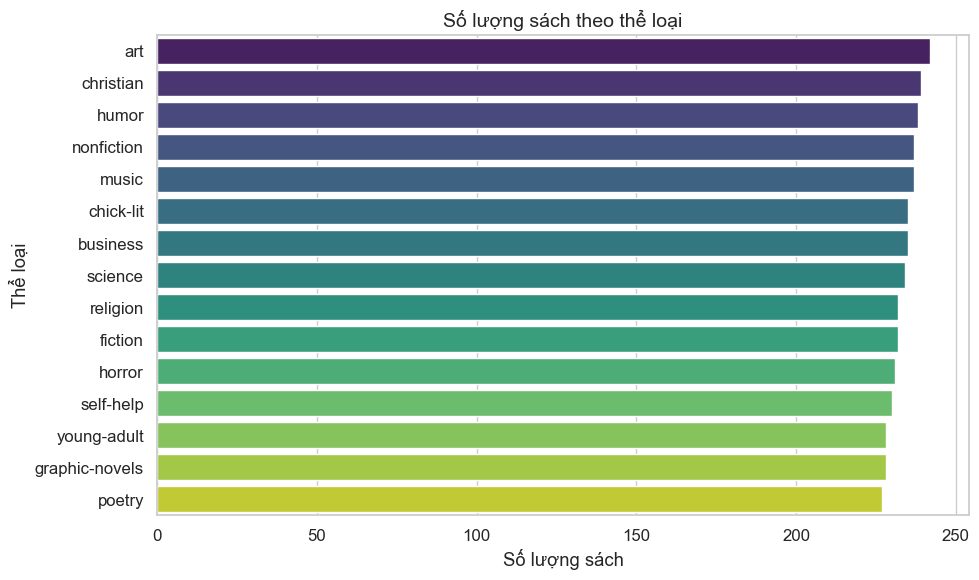

In [21]:
genre_count = (
    df_books
    .explode("genres_clean")
    .groupby("genres_clean")
    .size()
    .reset_index(name="Số lượng sách")
    .sort_values("Số lượng sách", ascending=False))

plt.figure()
sns.barplot(
    data=genre_count.head(15),
    x="Số lượng sách",
    y="genres_clean", palette='viridis')

plt.title("Số lượng sách theo thể loại", fontsize=14)
plt.xlabel("Số lượng sách")
plt.ylabel("Thể loại")
plt.tight_layout()
plt.show()

##### 2. Boxplot – Phân bố rating theo thể loại

C:\Users\NHU\AppData\Local\Temp\ipykernel_20028\1433421487.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




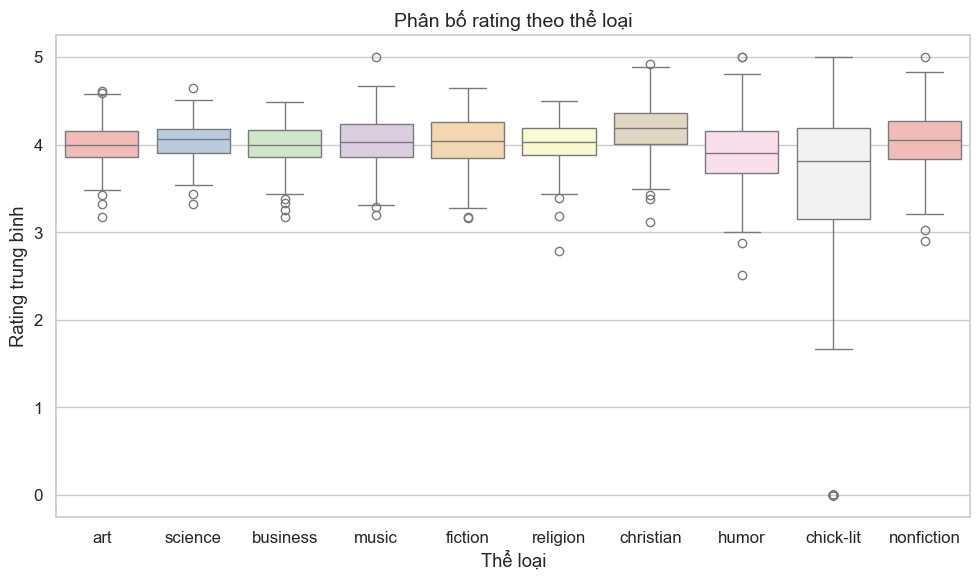

Biểu đồ này giúp so sánh chất lượng và mức độ ổn định của rating giữa các thể loại sách.
Biểu đồ boxplot thể hiện sự khác biệt trong phân bố rating trung bình giữa các thể loại sách phổ biến.
Kết quả cho thấy một số thể loại có mức rating cao và ổn định, trong khi các thể loại khác có độ phân tán lớn, phản ánh sự khác biệt trong cảm nhận của người đọc.
Ngoài ra, sự xuất hiện của các outlier cho thấy tồn tại những cuốn sách nhận được đánh giá rất cao hoặc rất thấp so với mặt bằng chung của thể loại.


In [45]:
rating_genre = df_books.explode("genres_clean")

plt.figure()
sns.boxplot(
    data=rating_genre[rating_genre["genres_clean"].isin(
        genre_count.head(10)["genres_clean"],
    )],
    x="genres_clean",
    y="avg_rating", palette='Pastel1')

plt.title("Phân bố rating theo thể loại", fontsize=14)
plt.xlabel("Thể loại")
plt.ylabel("Rating trung bình")
plt.tight_layout()
plt.show()
print("Biểu đồ này giúp so sánh chất lượng và mức độ ổn định của rating giữa các thể loại sách.")
print("Biểu đồ boxplot thể hiện sự khác biệt trong phân bố rating trung bình giữa các thể loại sách phổ biến.")
print("Kết quả cho thấy một số thể loại có mức rating cao và ổn định, trong khi các thể loại khác có độ phân tán lớn, phản ánh sự khác biệt trong cảm nhận của người đọc.")
print("Ngoài ra, sự xuất hiện của các outlier cho thấy tồn tại những cuốn sách nhận được đánh giá rất cao hoặc rất thấp so với mặt bằng chung của thể loại.")

##### 3. Biểu đồ tròn – Tỷ lệ review theo thể loại

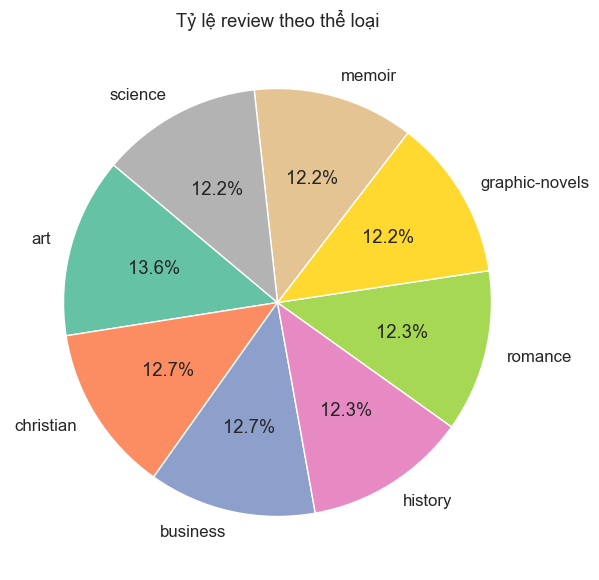

Biểu đồ tròn thể hiện tỷ lệ review theo các thể loại sách phổ biến.
Kết quả cho thấy một số thể loại chiếm tỷ trọng lớn trong tổng số review, phản ánh mức độ quan tâm cao của người đọc đối với các thể loại này.
Các thể loại còn lại chiếm tỷ lệ nhỏ hơn, cho thấy mức độ thảo luận hạn chế hơn.


In [46]:
review_by_genre = (
    df_reviews
    .explode("genres")
    .groupby("genres")
    .size()
    .reset_index(name="Số lượng review")
    .sort_values("Số lượng review", ascending=False))

plt.figure()
plt.pie(
    review_by_genre.head(8)["Số lượng review"],
    labels=review_by_genre.head(8)["genres"],
    autopct="%1.1f%%",
    startangle=140)

plt.title("Tỷ lệ review theo thể loại")
plt.tight_layout()
plt.show()
print("Biểu đồ tròn thể hiện tỷ lệ review theo các thể loại sách phổ biến.")
print("Kết quả cho thấy một số thể loại chiếm tỷ trọng lớn trong tổng số review, phản ánh mức độ quan tâm cao của người đọc đối với các thể loại này.")
print("Các thể loại còn lại chiếm tỷ lệ nhỏ hơn, cho thấy mức độ thảo luận hạn chế hơn.")

##### 4. Phân bố độ dài review

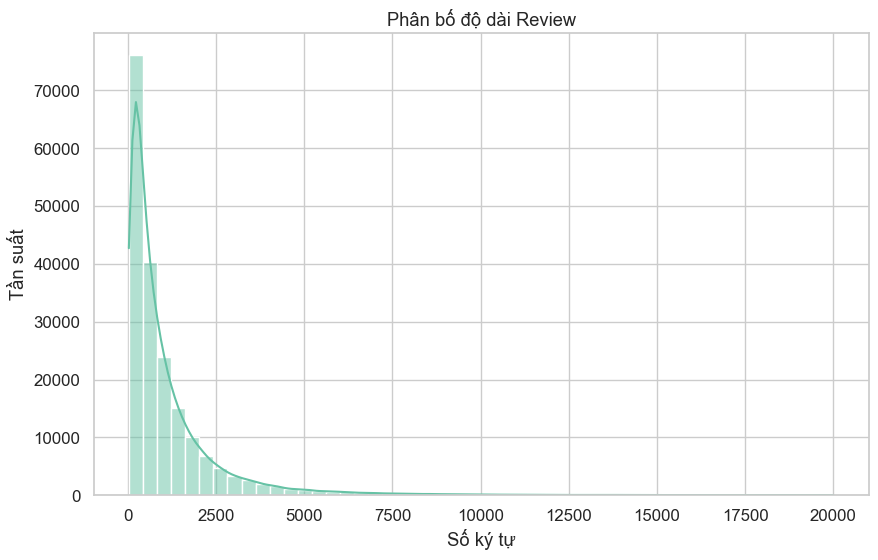

Biểu đồ phân bố độ dài review cho thấy phần lớn người dùng có xu hướng viết các đánh giá khoảng 256 – 1346 ký tự.
Điều này cho thấy người dùng thường viết review tương đối chi tiết.
Tuy nhiên, phân bố lệch phải cũng phản ánh sự tồn tại của một số review rất dài, phản ánh những đánh giá mang tính phân tích sâu.


In [44]:
plt.figure()
sns.histplot(df_reviews["review_length"], bins=50, kde=True)
plt.title("Phân bố độ dài Review")
plt.xlabel("Số ký tự")
plt.ylabel("Tần suất")
plt.show()
print("Biểu đồ phân bố độ dài review cho thấy phần lớn người dùng có xu hướng viết các đánh giá khoảng 256 – 1346 ký tự." )
print("Điều này cho thấy người dùng thường viết review tương đối chi tiết.")
print("Tuy nhiên, phân bố lệch phải cũng phản ánh sự tồn tại của một số review rất dài, phản ánh những đánh giá mang tính phân tích sâu.")

##### 5. Heatmap tương quan

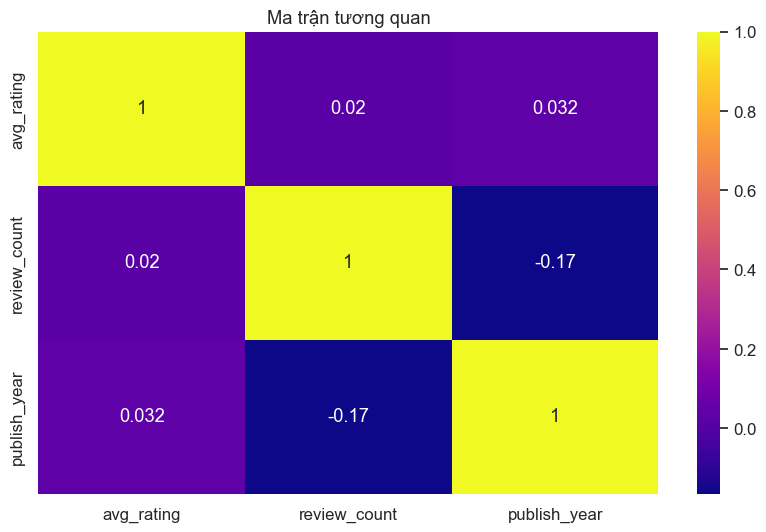

Ma trận tương quan cho thấy hệ số tương quan giữa số lượng review và rating trung bình là thấp.
Cho thấy mức độ phổ biến của sách không phản ánh trực tiếp chất lượng cảm nhận của người đọc.
Ngoài ra, năm xuất bản có mối tương quan dương nhẹ với số lượng review, cho thấy các sách xuất bản gần đây có xu hướng được quan tâm nhiều hơn.


In [58]:
plt.figure()
sns.heatmap(
    df_books[["avg_rating", "review_count", "publish_year"]].corr(),
    annot=True, cmap="plasma")
    
plt.title("Ma trận tương quan")
plt.show()

print("Ma trận tương quan cho thấy hệ số tương quan giữa số lượng review và rating trung bình là thấp.")
print("Cho thấy mức độ phổ biến của sách không phản ánh trực tiếp chất lượng cảm nhận của người đọc.")
print("Ngoài ra, năm xuất bản có mối tương quan dương nhẹ với số lượng review, cho thấy các sách xuất bản gần đây có xu hướng được quan tâm nhiều hơn.")

#### TRUY VẤN NÂNG CAO / BÀI TOÁN THỰC TẾ

##### 1. Tìm tất cả review của 1 sách cụ thể

In [60]:
book_name = "Memoirs of a Geisha"

book_id = df_books[df_books["title"] == book_name]["book_id"].iloc[0]

df_reviews[df_reviews["book_id"] == book_id][
    ["text", "created_at"]
].head(10)

,text,created_at
360,So.. Memoirs of a Geisha. I'd been wanting to ...,2025-12-27
361,"Memoirs of a Geisha is an American novel, and ...",2025-12-27
362,Like eating fancy dessert at a gourmet restaur...,2025-12-27
363,"”Whatever our struggles and triumphs, however ...",2025-12-27
364,Arthur Golden’s Memoirs of a Geisha is set in ...,2025-12-27
365,Damn if you aren't one of the most problematic...,2025-12-27
366,A timeless genre picture of a strong woman mak...,2025-12-27
367,This book was wonderful. I absolutely love the...,2025-12-27
368,I read this a long time ago ---(a favorite) --...,2025-12-27
369,I became fascinated with Japanese culture when...,2025-12-27


##### 2. Tìm review theo thể loại

In [ ]:
genre_search = "art"

df_reviews[
    df_reviews["genres"].apply(lambda x: genre_search in x)
][["text","text_vi", "book_id"]].drop_duplicates(subset="book_id").head(10)

,text,text_vi,book_id
0,Hey! Look at me stepping outside my comfort zo...,"Này, hãy nhìn vào tôi, tôi đã tìm thấy một cuố...",GR_10534
30,I like reading about organizing my life and be...,Tôi thích đọc về cách tổ chức cuộc sống và làm...,GR_1633
60,There is no rating low enough to compensate fo...,Không có đánh giá nào đủ thấp để bù đắp cho vi...,GR_22318578
90,Gladwell is taking a lot of heat for biasing t...,Gladwell đang bị chỉ trích nặng nề vì đã thiên...,GR_15751404
120,"If you follow my reviews/blog at all, you prob...",Nếu bạn theo dõi các bài đánh giá/blog của tôi...,GR_28257707
150,I feel like Robert M. Pirsig has wronged me pe...,Tôi có cảm giác như Robert M. Pirsig đã có lỗi...,GR_629
180,oh my god. This burrowed it's way deep into my...,Ôi chúa ơi. Điều này đã ăn sâu vào trái tim tô...,GR_15195
210,"Reflecting on my reading year 2016, I came to ...","Ngẫm lại năm đọc sách 2016 của mình, tôi nghĩ ...",GR_222078
240,A way to deal with the unspeakable that makes ...,Một cách để đối phó với những điều không thể d...,GR_15196
270,I was meandering around Borders one Saturday w...,Tôi đang dạo quanh Borders vào một ngày thứ Bả...,GR_3153910


##### 3. Tìm review chứa từ khóa tiêu cực / tích cực

In [26]:
# Hàm tính điểm cảm xúc (-1 là rất tiêu cực, 1 là rất tích cực)
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

df_reviews["sentiment_score"] = df_reviews["text"].apply(get_sentiment)

# Phân loại dựa trên điểm số
def phan_loai_cam_xuc(score):
    if score > 0.1: return "Tích cực"
    elif score < -0.1: return "Tiêu cực"
    else: return "Trung tính"

df_reviews["Cảm xúc"] = df_reviews["sentiment_score"].apply(phan_loai_cam_xuc)

print(df_reviews[["text", "Cảm xúc"]].head())

                                                text     Cảm xúc
0  Hey! Look at me stepping outside my comfort zo...  Trung tính
1  Simply put, Sun Tzu says that it is better not...    Tích cực
2  I definitely never thought i'd want to read a ...  Trung tính
3  The Art of Goodreads 1. Lotz says: The greates...    Tích cực
4  I thought this would contain more wisdom than ...    Tích cực


##### 4. Xếp hạng sách theo độ phổ biến

In [27]:
print ("Theo số lượng review")
top_popular = df_books.sort_values(
    "review_count", ascending=False
)[["title", "author", "review_count", "avg_rating"]].head(10)

top_popular.columns = ["title", "author", "review_count", "avg_rating"]

top_popular

Theo số lượng review


,title,author,review_count,avg_rating
6514,"Pride and Prejudice, Annotated: Jane Austen's ...",Jane Austen,4760868,4.29
3038,Jane Eyre: The Original 1847 Unabridged and Co...,Charlotte Brontë,2308388,4.16
12,Memoirs of a Geisha,Arthur Golden,2103426,4.16
3777,Wuthering Heights,Emily Brontë,2025457,3.90
3242,Frankenstien (4),Mary Wollstonecraft Shelley,1864259,3.90
3919,Frankenstein,Mary Wollstonecraft Shelley,1864259,3.90
2944,The Picture of Dorian Gray: Annotated Edition,Oscar Wilde,1857393,4.13
5642,The Time Traveler's Wife,Audrey Niffenegger,1854353,4.00
3058,Dracula,Bram Stoker,1464836,4.02
4,The Subtle Art of Not Giving a F*ck: A Counter...,Mark Manson,1389048,3.87


In [28]:
print("Theo chất lượng (rating cao + đủ review)")
top_quality = df_books[df_books["review_count"] >= 1000] \
    .sort_values("avg_rating", ascending=False) \
    [["title", "author", "avg_rating", "review_count"]] \
    .head(10)

top_quality.columns = ["title", "author", "avg_rating", "review_count"]

top_quality

Theo chất lượng (rating cao + đủ review)


,title,author,avg_rating,review_count
2722,Three James Herriot Classics: Volume 1,James Herriot,4.78,3858
5157,文豪ストレイドッグス BEAST 4,Shiwasu Hoshikawa(Adaptor),4.77,1417
5630,Fantasy in Death / Indulgence in Death / Treac...,J.D. Robb,4.73,2616
2214,The Only Plane in the Sky: An Oral History of ...,Garrett M. Graff,4.72,44094
2403,"Foster the Family: Encouragement, Hope, and Pr...",Jamie C. Finn,4.72,1454
7152,The Only Plane in the Sky: An Oral History of ...,Garrett M. Graff,4.72,44096
7003,Invisible Child: Winner of the Pulitzer Prize ...,Andrea Elliott,4.70,19156
2135,How the Word Is Passed: A Reckoning with the H...,Clint Smith,4.70,39300
5830,Know My Name: A Memoir,Chanel Miller,4.68,255246
3800,Refuge of Redemption: The Colsons,Christy Barritt,4.68,1151


##### 5. Biểu đồ xếp hạng sách phổ biến nhất

C:\Users\NHU\AppData\Local\Temp\ipykernel_20028\3472763478.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\NHU\AppData\Local\Temp\ipykernel_20028\3472763478.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


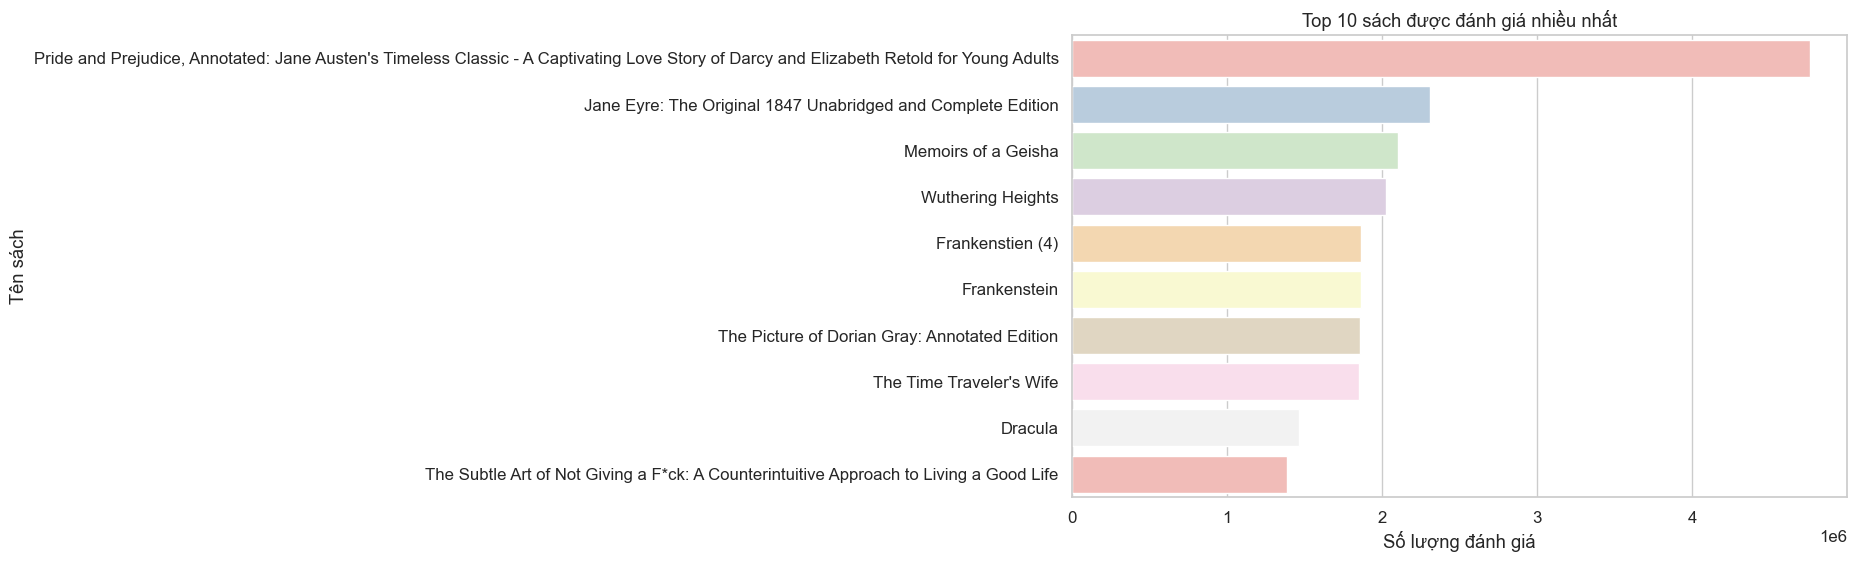

In [29]:
plt.figure()
sns.barplot(
    data=top_popular,
    x="review_count",
    y="title", palette='Pastel1')

plt.title("Top 10 sách được đánh giá nhiều nhất")
plt.xlabel("Số lượng đánh giá")
plt.ylabel("Tên sách")
plt.tight_layout()
plt.show()

##### 6. Biểu đồ WordCloud

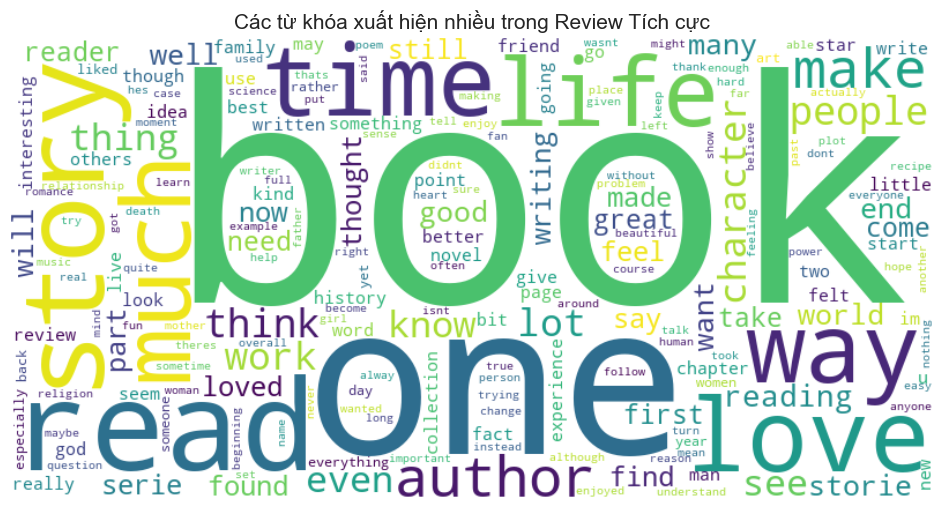

In [30]:
# Lấy toàn bộ text từ các review tích cực
text_positive = " ".join(review for review in df_reviews[df_reviews["Cảm xúc"]=="Tích cực"]["text_clean"])

# Tạo WordCloud
wc = WordCloud(width=800, height=400, background_color ='white', colormap='viridis').generate(text_positive)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Các từ khóa xuất hiện nhiều trong Review Tích cực", fontsize=15)
plt.show()

##### 7. Biểu đồ Scatter Plot (Tương quan giữa độ nổi tiếng và chất lượng)

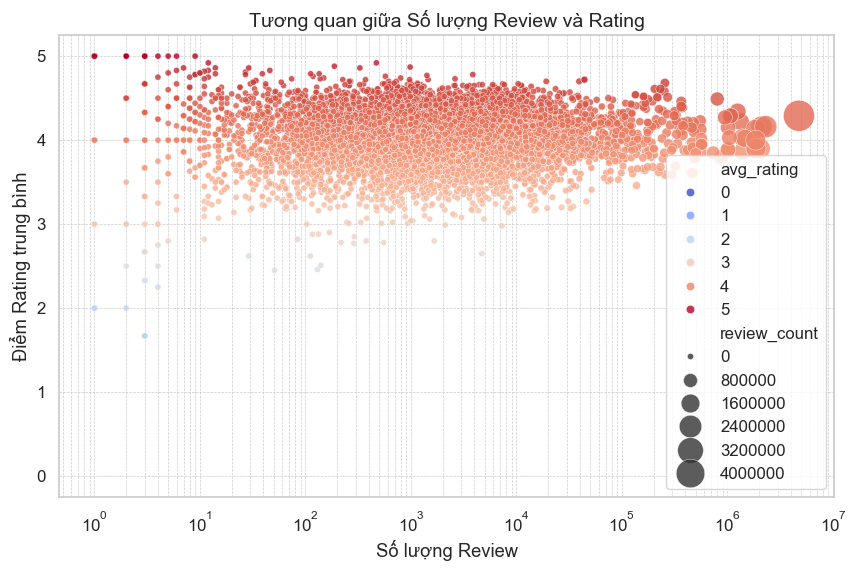

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_books,
    x="review_count",
    y="avg_rating",
    alpha= 0.8,
    hue="avg_rating",
    palette="coolwarm",
    size="review_count",
    sizes=(20, 500),
)

plt.title("Tương quan giữa Số lượng Review và Rating", fontsize=14)
plt.xlabel("Số lượng Review")
plt.ylabel("Điểm Rating trung bình")
plt.xscale('log') # Dùng log scale nếu chênh lệch review quá lớn
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

##### 8. Tính năng "Gợi ý sách"

In [84]:
# Gợi ý sách cùng thể loại có rating cao nhất
def recommend_books(genre_input, top_n=5):
    # Lọc sách theo thể loại
    books_genre = df_books[df_books["genres_clean"].apply(lambda x: genre_input.lower() in x)]

    if books_genre.empty:
        return "Không tìm thấy sách thể loại này!"

    # Sắp xếp theo rating và lượng review (để tránh sách 5 sao nhưng chỉ có 1 review)
    recommendations = books_genre[books_genre["review_count"] > 50].sort_values("avg_rating", ascending=False).head(top_n)

    return recommendations[["title", "author", "avg_rating", "book_url"]]

# Thử nghiệm
print("--- Gợi ý cho bạn sách thể loại 'art' ---")
print(recommend_books("art"))

print("--------------------------------------------------------------------------")
print("Hàm gợi ý sách được xây dựng dựa trên thể loại và mức rating tối thiểu, nhằm đề xuất các cuốn sách có chất lượng cao và được cộng đồng đánh giá tốt.")
print("Kết quả được sắp xếp ưu tiên theo rating và độ phổ biến.")
print("Kết quả gợi ý sách được hiển thị dưới dạng bảng, bao gồm tiêu đề, tác giả, rating trung bình và liên kết sách.")
print("Điều này cho phép người dùng dễ dàng đánh giá và lựa chọn các cuốn sách phù hợp với sở thích.")

--- Gợi ý cho bạn sách thể loại 'art' ---
                                                 title                      author  avg_rating                                           book_url
13               The Art of The Fellowship of the Ring                Gary Russell        4.61  https://www.goodreads.com/book/show/119.The_Ar...
243  The Art of George R.R. Martin's A Song of Ice ...  Patricia  Meredith(Editor)        4.59  https://www.goodreads.com/book/show/13560586-t...
6                                    The Complete Maus              Art Spiegelman        4.58  https://www.goodreads.com/book/show/15195.The_...
122  Red Comet: The Short Life and Blazing Art of S...             Heather   Clark        4.57  https://www.goodreads.com/book/show/48721389-r...
102  Avatar The Last Airbender: The Art of the Anim...     Michael Dante DiMartino        4.55  https://www.goodreads.com/book/show/7642606-av...
--------------------------------------------------------------------------
Hàm gợi

##### 9. Biểu đồ tương quan giữa Rating và Số lượng Review

In [47]:
import plotly.express as px

df_plot = df_books[df_books['review_count'] >= 5000]
fig = px.scatter(
    df_plot,
    x="review_count",
    y="avg_rating",
    size="review_count",
    color="avg_rating",
    hover_name="title",
    hover_data=["author", "genres_clean"],
    log_x=True,
    labels={
        "review_count": "Số lượng Review",
        "avg_rating": "Điểm Rating trung bình"
    },
    title="Tương quan giữa Độ phổ biến và Chất lượng (≥ 1000 review)",
    template="plotly_white"
)
fig.update_layout(
    title_x=0.5)

fig.show()
print("Biểu đồ phân tán thể hiện mối quan hệ giữa số lượng review và điểm rating trung bình của sách.")
print("Kết quả cho thấy các cuốn sách có số lượng review lớn không phải lúc nào cũng đạt rating cao, cho thấy mức độ phổ biến không hoàn toàn phản ánh chất lượng cảm nhận của người đọc.")

Biểu đồ phân tán thể hiện mối quan hệ giữa số lượng review và điểm rating trung bình của sách.
Kết quả cho thấy các cuốn sách có số lượng review lớn không phải lúc nào cũng đạt rating cao, cho thấy mức độ phổ biến không hoàn toàn phản ánh chất lượng cảm nhận của người đọc.


##### 10. Cảm xúc theo thể loại

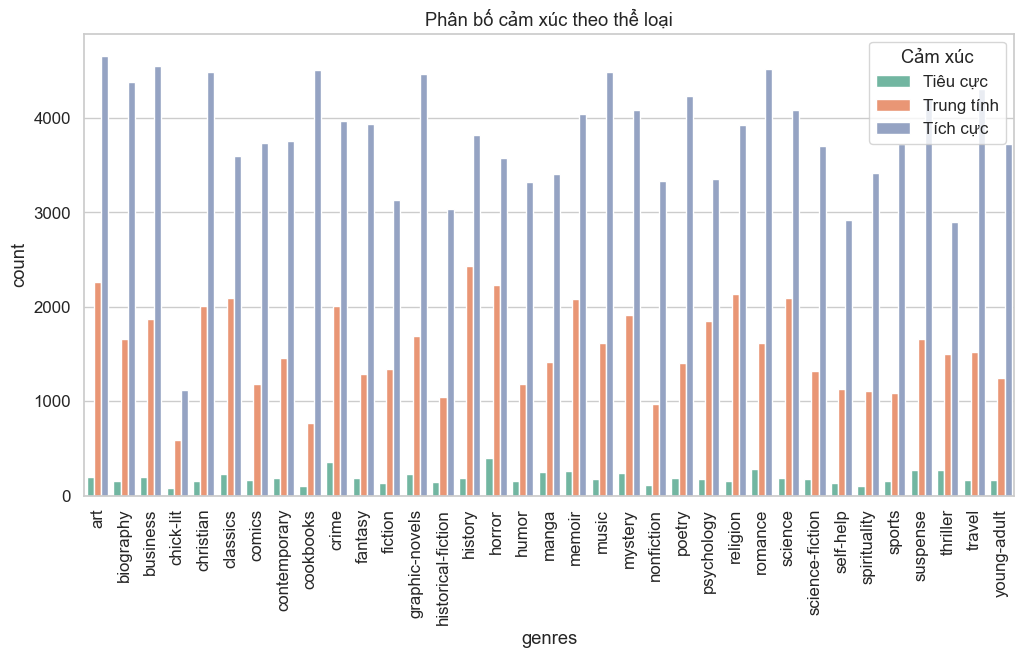

Biểu đồ thể hiện phân bố cảm xúc của người đọc theo từng thể loại sách.
Kết quả cho thấy một số thể loại như Fantasy và Romance nhận được nhiều đánh giá tích cực hơn, trong khi một số thể loại khác có tỷ lệ cảm xúc tiêu cực cao hơn.
Phản ánh sự khác biệt trong mức độ hài lòng của độc giả giữa các thể loại.


In [70]:
sentiment_genre = (
    df_reviews.explode("genres")
    .groupby(["genres", "Cảm xúc"])
    .size()
    .reset_index(name="count")
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=sentiment_genre,
    x="genres",
    y="count",
    hue="Cảm xúc"
)
plt.xticks(rotation=90)
plt.title("Phân bố cảm xúc theo thể loại")
plt.show()

print("Biểu đồ thể hiện phân bố cảm xúc của người đọc theo từng thể loại sách.")
print("Kết quả cho thấy một số thể loại như Fantasy và Romance nhận được nhiều đánh giá tích cực hơn, trong khi một số thể loại khác có tỷ lệ cảm xúc tiêu cực cao hơn.")
print("Phản ánh sự khác biệt trong mức độ hài lòng của độc giả giữa các thể loại.")

##### 11. Tìm kiếm tác giả "Phong độ ổn định nhất"

In [34]:
author_stats = df_books.groupby('author').agg({
    'avg_rating': ['mean', 'std', 'count']})

author_stats.columns = ['Rating trung bình', 'Độ lệch chuẩn', 'Số lượng sách']

# Lọc: Ít nhất 3 sách
consistent_authors = author_stats[author_stats['Số lượng sách'] >= 3]

# Rating trung bình cao và Độ lệch chuẩn thấp (ít biến động)
top_authors = consistent_authors.sort_values(by=['Rating trung bình', 'Độ lệch chuẩn'], ascending=[False, True])

print("--- TOP 10 TÁC GIẢ VIẾT ĐỀU TAY NHẤT ---")
print(top_authors.head(10))

--- TOP 10 TÁC GIẢ VIẾT ĐỀU TAY NHẤT ---
                     Rating trung bình  Độ lệch chuẩn  Số lượng sách
author                                                              
Lincoln Peirce                4.596316       0.098331             19
Highlights(Creator)           4.592500       0.354906              4
Zara Evans                    4.592000       0.110318              5
Christy Barritt               4.578333       0.072718             12
Elle Gray                     4.562000       0.075248             10
Zack Zombie Comics            4.553333       0.098150              3
Leah Moyes                    4.545000       0.121244              4
Robert  Bailey                4.540000       0.040000              3
J.D. Kirk                     4.517619       0.109037             21
Dan     Walsh                 4.515714       0.178406              7


##### 12. Sentiment trung bình theo sách

In [ ]:
book_sentiment = (
    df_reviews.groupby("book_id")["sentiment_score"]
    .mean()
    .reset_index()
)

df_books = df_books.merge(book_sentiment, on="book_id", how="left")

C:\Users\NHU\AppData\Local\Temp\ipykernel_20028\1627967116.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



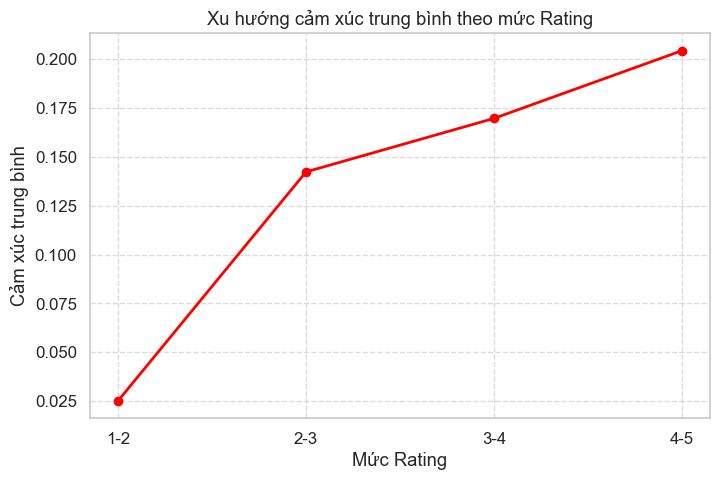

Biểu đồ cho thấy cảm xúc trung bình tăng dần theo mức rating.
Các cuốn sách có rating cao thường đi kèm với cảm xúc tích cực hơn trong review, cho thấy sự phù hợp giữa điểm đánh giá và nội dung nhận xét của người đọc.


In [74]:
# Lọc dữ liệu hợp lệ
df_plot = df_books.dropna(subset=["avg_rating", "sentiment_score"]).copy()

# Chia rating thành các mức
df_plot["rating_group"] = pd.cut(
    df_plot["avg_rating"],
    bins=[0, 2, 3, 4, 5],
    labels=["1-2", "2-3", "3-4", "4-5"])

# Tính sentiment trung bình theo mức rating
rating_sentiment = (
    df_plot
    .groupby("rating_group")["sentiment_score"]
    .mean())


plt.figure(figsize=(8, 5))

# Vẽ biểu đồ đường với điểm đánh dấu
plt.plot(rating_sentiment.index, rating_sentiment.values, marker='o', linestyle='-', color='r', linewidth=2)

# Thêm lưới để dễ nhìn
plt.grid(True, linestyle='--', alpha=0.7)

plt.xlabel("Mức Rating")
plt.ylabel("Cảm xúc trung bình")
plt.title("Xu hướng cảm xúc trung bình theo mức Rating")
plt.show()

print("Biểu đồ cho thấy cảm xúc trung bình tăng dần theo mức rating.")
print("Các cuốn sách có rating cao thường đi kèm với cảm xúc tích cực hơn trong review, cho thấy sự phù hợp giữa điểm đánh giá và nội dung nhận xét của người đọc.")

##### 13. Rating trung bình theo năm phát hành

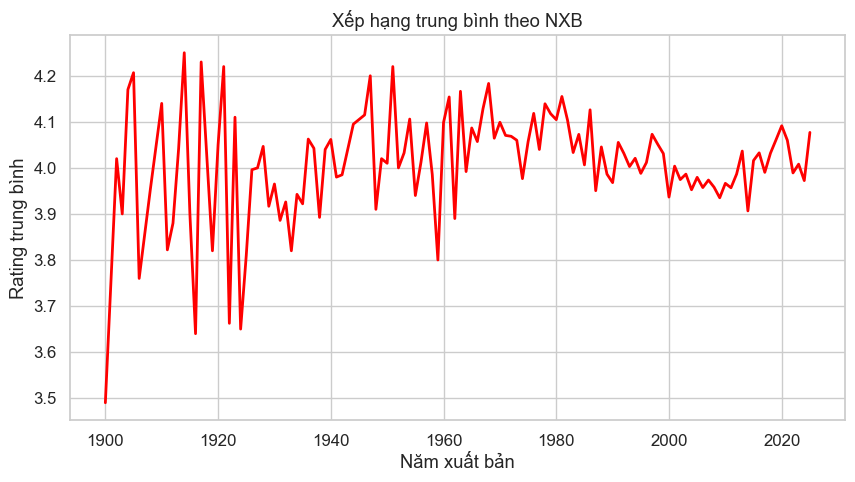

In [80]:
df_year = df_books[(df_books['publish_year'] >= 1900) & (df_books['publish_year'] <= 2025)]
year_avg = df_year.groupby('publish_year')['avg_rating'].mean()

plt.figure(figsize=(10,5))
year_avg.plot(color='red', linewidth=2)
plt.title("Xếp hạng trung bình theo NXB")
plt.xlabel("Năm xuất bản")
plt.ylabel("Rating trung bình")
plt.show()

##### 14. Sách bị đánh giá thấp (rating cao, ít review)

In [81]:
print("\n Sách bị đánh giá thấp")
underrated = df_books[(df_books['avg_rating'] >= 4.5) & (df_books['review_count'] < 1000)]
print(underrated[['title', 'avg_rating', 'review_count']].head(10))


 Sách bị đánh giá thấp
                                                  title  avg_rating  review_count
542   Leeta Simtar—A Life on Two Planets: The Unauth...        4.54            68
579   Five Mere Christians: Binge-Worthy Biographies...        4.58           393
609                                 Pessoa: A Biography        4.53           413
675       Walk with Me: A Biography of Fannie Lou Hamer        4.50           286
720   Religion of the Apostles: Orthodox Christianit...        4.50           753
734   To Rescue the American Spirit: Teddy Roosevelt...        4.61           700
947   The Inconvenient Gospel: A Southern Prophet Ta...        4.50            92
954   After Purity: Race, Sex, and Religion in White...        4.50            14
1124                                  A Song of Silence        4.59           802
1129  The Secret Orphan Sisters: A WWII historical f...        4.55           859


##### 15. Sách cường điệu quá mức (nhiều review, rating thấp)

In [82]:
threshold = df_books['review_count'].quantile(0.8)
overhyped = df_books[(df_books['avg_rating'] < 3.5) & (df_books['review_count'] > threshold)]
print("\nSách cường điệu quá mức")
print(overhyped[['title', 'avg_rating', 'review_count']].head(10))


Sách cường điệu quá mức
                                                  title  avg_rating  review_count
72             The Gentle Art of Swedish Death Cleaning        3.42         32220
894                                A Dangerous Business        3.17          8819
1053                                  Too Hot to Handle        3.27         30963
1095                                   Too Wild to Tame        3.34         14765
1110                                 Too Hard to Forget        3.41         13238
1119                             Too Beautiful to Break        3.35         11531
1273  Where Or When: A Gripping Contemporary Romance...        3.31          8866
1805  Unfuck Your Brain: Using Science to Get Over A...        3.32         21887
1845  How to Live Safely in a Science Fictional Univ...        3.44         20245
2300                                  History of Wolves        3.40         29371


#### CLUSTERING (ML)

In [87]:
features = df_books[['avg_rating', 'review_count']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

##### 1. Elbow Method

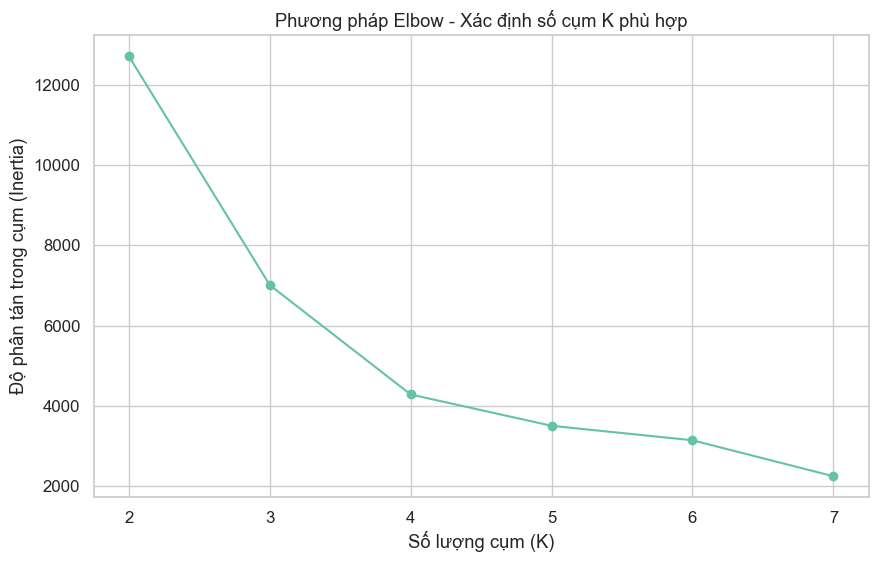

Phương pháp Elbow được sử dụng để xác định số cụm K phù hợp cho thuật toán KMeans.
Kết quả cho thấy inertia giảm mạnh khi tăng K từ 2 lên 3, sau đó mức giảm chậm dần.
Do đó, K = 3 được lựa chọn vì cân bằng giữa độ chặt của cụm và độ phức tạp của mô hình và phân nhóm sách.
Inertia (Độ lộn xộn trong mỗi nhóm)
Inertia cao → các sách trong 1 nhóm không giống nhau
Inertia thấp → các sách trong 1 nhóm giống nhau hơn


In [91]:
inertia = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(features_scaled)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(K, inertia, marker="o")
plt.title("Phương pháp Elbow - Xác định số cụm K phù hợp")
plt.xlabel("Số lượng cụm (K)")
plt.ylabel("Độ phân tán trong cụm (Inertia)")
plt.show()

print("Phương pháp Elbow được sử dụng để xác định số cụm K phù hợp cho thuật toán KMeans.")
print("Kết quả cho thấy inertia giảm mạnh khi tăng K từ 2 lên 3, sau đó mức giảm chậm dần.")
print("Do đó, K = 3 được lựa chọn vì cân bằng giữa độ chặt của cụm và độ phức tạp của mô hình và phân nhóm sách.")
print("Inertia (Độ lộn xộn trong mỗi nhóm)")
print("Inertia cao → các sách trong 1 nhóm không giống nhau")
print("Inertia thấp → các sách trong 1 nhóm giống nhau hơn")

##### 2. GẮN NHÃN CHO CỤM (CLUSTER)

In [95]:
cluster_label = {
    0: "Ít review - Rating cao",
    1: "Nhiều review - Rating trung bình",
    2: "Phổ thông"}

print("Sau khi phân cụm dữ liệu sách dựa trên rating và số lượng review, các cụm được gán nhãn mô tả nhằm tăng khả năng diễn giải")
print("Bao gồm nhóm sách ít review nhưng được đánh giá cao, nhóm sách phổ biến với rating trung bình và nhóm sách phổ thông.")

df_books["cluster_label"] = df_books["cluster"].map(cluster_label)
df_books[["title", "avg_rating", "review_count", "cluster", "cluster_label"]].head(10)



Sau khi phân cụm dữ liệu sách dựa trên rating và số lượng review, các cụm được gán nhãn mô tả nhằm tăng khả năng diễn giải
Bao gồm nhóm sách ít review nhưng được đánh giá cao, nhóm sách phổ biến với rating trung bình và nhóm sách phổ thông.


,title,avg_rating,review_count,cluster,cluster_label
0,The Art of War,3.95,566644,0,Ít review - Rating cao
1,Getting Things Done: The Art of Stress-Free Pr...,4.00,167407,0,Ít review - Rating cao
2,The Life-Changing Magic of Tidying Up: The Jap...,3.88,391098,0,Ít review - Rating cao
3,"David and Goliath: Underdogs, Misfits, and the...",3.97,191237,0,Ít review - Rating cao
4,The Subtle Art of Not Giving a F*ck: A Counter...,3.87,1389048,1,Nhiều review - Rating trung bình
5,Zen and the Art of Motorcycle Maintenance: An ...,3.78,244580,0,Ít review - Rating cao
6,The Complete Maus,4.58,252414,0,Ít review - Rating cao
7,The Story of Art,3.97,461288,0,Ít review - Rating cao
8,Maus I: A Survivor's Tale: My Father Bleeds Hi...,4.39,372998,0,Ít review - Rating cao
9,The Art of Racing in the Rain,4.23,552497,0,Ít review - Rating cao
